In [1]:
from cgeniepy.ecology import EcoModel
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

k_model = EcoModel("../model/muffin.u067bc.PO4Fe.SPIN", gemflag=['biogem', 'ecogem'])
kpg_model = EcoModel("../model/muffin.u067bc.PO4Fe.main", gemflag=['biogem', 'ecogem'])
danian = EcoModel("../model/muffin.u067bc.PO4Fe.Danian/", gemflag=['biogem','ecogem'])
danian_noextinction = EcoModel("../model/muffin.u067bc.PO4Fe.Danian.noextinction/", gemflag=['biogem','ecogem'])
danian_nose = EcoModel("../model/muffin.u067bc.PO4Fe.Danian.size_effect/", gemflag=['biogem','ecogem'])

In [2]:
def get_ts_plus(var):
    var_k = kpg_model.get_ts(var)
    var_danian = danian.get_ts(var)
    var_danian['time (yr)'] += 200  # add year 200 to match the main experiment

    var_full = pd.concat([var_k, var_danian], ignore_index=True)
    var_full = var_full.iloc[75:]

    var_full['time (yr)'] -= 100  # both time - 100 to get relative time to K-PG

    return var_full

In [3]:
danian.get_var("carb_sur_pHsws")

GriddedData
data=<xarray.DataArray 'carb_sur_pHsws' (time: 12, lat: 36, lon: 36)> Size: 62kB
[15552 values with dtype=float32]
Coordinates:
  * time     (time) float64 96B 0.5 1.5 4.5 9.5 19.5 ... 499.5 999.5 2e+03 5e+03
  * lon      (lon) float64 288B -175.0 -165.0 -155.0 ... 155.0 165.0 175.0
  * lat      (lat) float64 288B -76.46 -66.44 -59.44 ... 59.44 66.44 76.46
Attributes:
    long_name:  surface pHsws
    units:      mol kg$^{-1}$

In [4]:
def get_danian_d13C(danian_model):
    #13C gradient
    d13C = kpg_model.get_ts("ocn_DIC_13C")
    d13C['gradient'] = d13C['surface (ice-free) DIC_13C (o/oo)']

    d13C_danian = danian_model.get_ts("ocn_DIC_13C")
    d13C_danian['gradient'] = d13C_danian['surface (ice-free) DIC_13C (o/oo)'] - d13C['surface (ice-free) DIC_13C (o/oo)']
    d13C_danian['time (yr)'] += 200  # add year 200 to match the main experiment

    ## both time - 100 to get relative time to K-PG
    d13C['time (yr)'] -= 100
    d13C_danian['time (yr)'] -= 100

    plot_time = pd.concat([d13C['time (yr)']/1e3, d13C_danian['time (yr)']/1e3])
    plot_d13C = pd.concat([d13C['surface (ice-free) DIC_13C (o/oo)'], d13C_danian['surface (ice-free) DIC_13C (o/oo)']])
    
    return plot_time, plot_d13C

In [5]:
def get_pH(model):
    pH = model.get_var("carb_pHsws")

    sur_pH = pH.isel(zt=0).mean(dim=['lat','lon'])
    ben_pH = pH.sel(zt=slice(2000, None)).mean(dim=['lat','lon','zt'])

    return sur_pH, ben_pH

In [6]:
pH_sur, pH_ben= get_pH(danian)

Text(0.5, 0, 'Time relative to K-Pg (yr)')

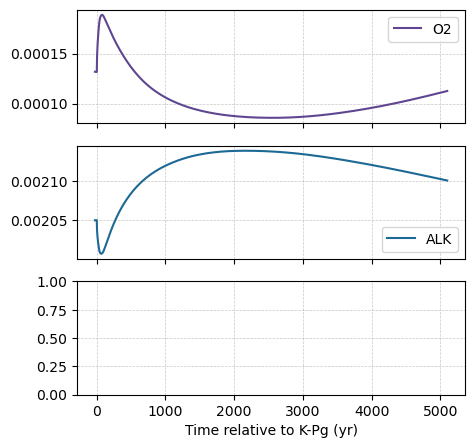

In [7]:
o2_full = get_ts_plus("ocn_O2")
alk_full = get_ts_plus("ocn_ALK")

fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True)

from palettable.cartocolors.qualitative import Prism_3

o2_full.plot(x='time (yr)', y ='benthic [> 2000 m] O2 (mol kg-1)', ax=axs[0], color=Prism_3.mpl_colors[0], label='O2')
alk_full.plot(x='time (yr)', y ='benthic [> 2000 m] ALK (mol kg-1)', ax=axs[1], color=Prism_3.mpl_colors[1], label='ALK')

axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.xlabel('Time relative to K-Pg (yr)')

#plt.savefig('../output/longterm_envs.png', dpi=300, bbox_inches='tight')

In [ ]:
colors = Prism_3.mpl_colors
## use Hevletica font
plt.rcParams['font.family'] = 'Helvetica'

# --- Load observational data for Site 1209 ---
obs_1209 = pd.read_csv("../data/Hull2020_S13.csv")
obs_1209['Age_after_KPg_Ma'] = 66.022 - obs_1209['Age']
obs_1209['kyr'] = obs_1209['Age_after_KPg_Ma'] * 1e3
obs_1209 = obs_1209[obs_1209['Age_after_KPg_Ma'] < 0.3]

# --- Load observational data for Site U1403 ---
obs_u1403 = pd.read_csv("../data/Hull2020_S12.csv")
obs_u1403['Age_after_KPg_Ma'] = 66.022 - obs_u1403['Age']
obs_u1403['kyr'] = obs_u1403['Age_after_KPg_Ma'] * 1e3
obs_u1403 = obs_u1403[obs_u1403['Age_after_KPg_Ma'] < 0.3]

# Split obs into pre- and post- segments (Site 1209 shown here; replicate for U1403 if desired)
obs_1209pre  = obs_1209[(obs_1209['kyr'] >= -60) & (obs_1209['kyr'] <=   0)]
obs_1209post = obs_1209[(obs_1209['kyr'] >=   5) & (obs_1209['kyr'] <=  50)]
obs_u1403pre  = obs_u1403[(obs_u1403['kyr'] >= -60) & (obs_u1403['kyr'] <=   0)]
obs_u1403post = obs_u1403[(obs_u1403['kyr'] >=   5) & (obs_u1403['kyr'] <=  50)]

obs_1262 = pd.read_csv("../data/Hull2020_S10.csv")
obs_1262['Age_after_KPg_Ma'] = 66.022 - obs_1262['Age']
obs_1262['kyr'] = obs_1262['Age_after_KPg_Ma'] * 1e3
obs_1262 = obs_1262[obs_1262['Age_after_KPg_Ma'] < 0.3]

# Split obs into pre- and post- segments (Site 1262 shown here; replicate for U1403 if desired)
obs_1262pre  = obs_1262[(obs_1262['kyr'] >= -60) & (obs_1262['kyr'] <=   0)]
obs_1262post = obs_1262[(obs_1262['kyr'] >=   5) & (obs_1262['kyr'] <=  50)]

# --- Create the broken‐axis figure ---
fig = plt.figure(figsize=(7.5, 3))
gs  = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)

# Panel 1: obs –60→0 kyr
ax1.scatter(obs_1209pre['kyr'], obs_1209pre['d13C'], s=20, label='Site 1209', color=colors[0], alpha=0.7)
ax1.scatter(obs_u1403pre['kyr'], obs_u1403pre['d13C'], s=20, label='U1403', color=colors[1], alpha=0.7)
ax1.scatter(obs_1262pre['kyr'], obs_1262pre['d13C'], s=20, label='Site 1262', color=colors[2],  alpha=0.7)
#ax1.axvline(0, color='k', linestyle='--')
ax1.set_xlim(-60, 0)
ax1.set_ylabel('δ¹³C (‰)')

# # Panel 2: model 0→5 kyr
plot_time, plot_d13C = get_danian_d13C(danian)
ax2.plot(plot_time, plot_d13C, color='k', label='Model', linewidth=1.5)

ax2.set_xlim(-0.02, 5)
ax2.set_xlabel('Time relative to K-Pg (kyr)')

# Panel 3: obs 5→50 kyr
ax3.scatter(obs_1209post['kyr'], obs_1209post['d13C'], s=20, label='ODP 1209', color=colors[0], alpha=0.7)
ax3.scatter(obs_u1403post['kyr'], obs_u1403post['d13C'], s=20, label='IODP U1403', color=colors[1], alpha=0.7)
ax3.scatter(obs_1262post['kyr'], obs_1262post['d13C'], s=20, label='ODP 1262', color=colors[2], alpha=0.7)
ax3.set_xlim(5, 50)
# nobox 
ax2.legend(fontsize=9, shadow=False, frameon=False, loc='lower right')
ax3.legend(fontsize=9, shadow=False, frameon=False, loc='lower right')

# Hide inner spines & ticks
for ax in (ax1, ax2, ax3):
    #ax.spines['top'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.5)

ax1.spines['right'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax3.spines['left'].set_visible(False)

ax1.tick_params(labelleft=True, right=False)
ax2.tick_params(labelleft=False, left=False, right=False, labelright=False)
ax3.tick_params(left=False, right=True, labelleft=False, labelright=False)

## add broken symbol in 
# size of the diagonal lines in axes coordinates
d = .01  
lw = 1.0
# break marks between ax1 and ax2
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=lw)
# lower diagonal
ax1.plot([1-d, 1+d], [-d, d],     **kwargs)
# upper diagonal
ax1.plot([1-d, 1+d], [1-d, 1+d], **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot([-d, d], [-d, d],         **kwargs)
ax2.plot([-d, d], [1-d, 1+d],     **kwargs)

# break marks between ax2 and ax3
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False, linewidth=lw)
ax2.plot([1-d, 1+d], [-d, d],      **kwargs)
ax2.plot([1-d, 1+d], [1-d, 1+d],  **kwargs)

kwargs.update(transform=ax3.transAxes)
ax3.plot([-d, d], [-d, d],         **kwargs)
ax3.plot([-d, d], [1-d, 1+d],     **kwargs)

plt.tight_layout()
plt.show()

## save to fig
fig.savefig("../output/d13C_comparison.png", dpi=300, bbox_inches='tight')

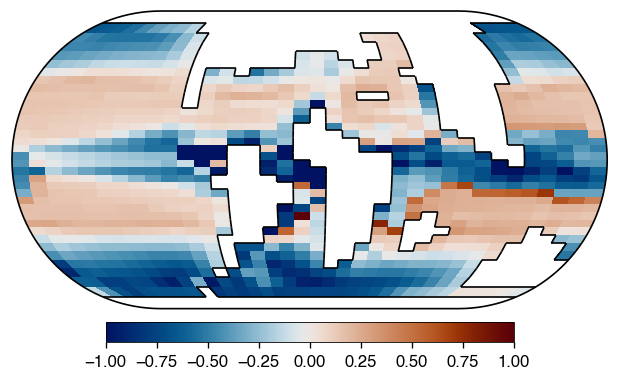

In [9]:
import cmcrameri.cm as cmc 
import xarray as xr

cmap = cmc.vik

arctic_mask = xr.load_dataarray("../data/masked_array.nc")

poc_preimpact = k_model.get_var("bio_fexport_POC").isel(time=-1)
poc_postimpact = danian.get_var("bio_fexport_POC").isel(time=-1)

poc_anomaly = poc_postimpact - poc_preimpact
poc_anomaly.data = poc_anomaly.data/1e12
poc_anomaly.attrs['units'] = 'Tmol C yr$^{-1}$'

# mask the arctic region
poc_anomaly = poc_anomaly * arctic_mask

poc_anomaly.plot(colorbar=True, outline=True, vmin=-1, vmax=1,contour=False, levels=[0], cmap=cmap)
plt.savefig('../output/poc_diff.png', dpi=300, bbox_inches='tight')